# Improts and setup

### Setup envirnonment 

In [1]:
%load_ext autoreload
%autoreload 2

### Import necessaary libraries

In [2]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets

import tempfile
from urllib.request import urlretrieve
import tarfile
import os

import json
import matplotlib.pyplot as plt

import PIL
import numpy as np

import imp

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Import custom libraries

In [3]:
import patch_utils
import image_utils

In [4]:
imp.reload(patch_utils)
imp.reload(image_utils)

<module 'image_utils' from '/home/slavchic/Desktop/209AS_winter_2020/python_files/image_utils/__init__.py'>

# Workspace

### Load labels

In [5]:
imagenet_json, _ = urlretrieve(
    'http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)### Choose an image

### Choose an image

In [6]:
# specify training set
number_of_images = 3
folder_with_images = "ImageNet/training_set"
folder_for_patch_chkpt = "./patch_weights/shift_rotate/"


# specify the patch size, mean, std
mean = 0
std = 0.3
size = 80


# get patch initializer
patch_init = np.random.normal(mean, std, (size, size, 3))
mask = np.abs(patch_init) < 1
patch_init *= mask
patch_init = patch_init.astype(np.float32)


# get train images 
train_set = image_utils.sample_image_wrapper(number_of_images, folder_with_images)

### Graph setup

In [7]:
# somewhy utils do not automatically reload; so we have to do it manually
imp.reload(patch_utils)

# Allows not to reboot kernel on each initialization
tf.reset_default_graph() 


# ============================================================================= #
# ============================= declare variables ============================= #
# ============================================================================= #



# declare variable for adversarial patch
naive_patch = tf.get_variable(name="patch", initializer=patch_init, dtype=tf.float32)


# declare a placeholder for the image
train_images = tf.placeholder(name="train_images", shape=(number_of_images, 300, 300, 3), dtype=tf.float32)

# declare shifts
x_shifts = tf.placeholder(name="x_shifts", shape=(), dtype=tf.int32)
y_shifts = tf.placeholder(name="y_shifts", shape=(), dtype=tf.int32)

# declare learning rate
learning_rate = tf.placeholder(tf.float32, ())

# declare target class
target_class = tf.placeholder(tf.int32, ())    

# declare initializer for variables
patch_initializer = tf.variables_initializer([naive_patch])

# fold parameters
start_x = tf.placeholder(name="start_x", shape=(), dtype=tf.int32)
start_y = tf.placeholder(name='start_y', shape=(), dtype=tf.int32)
end_x = tf.placeholder(name='end_x', shape=(), dtype=tf.int32)
end_y = tf.placeholder(name='end_y', shape=(), dtype=tf.int32)
thickness = tf.placeholder(name="thickness", shape=(), dtype=tf.int32)

# rotation
degrees = tf.placeholder(name='degrees', shape=(), dtype=tf.float32)


# ============================================================================= #
# ========================== preprocessing operations ========================= #
# ============================================================================= #


# multiply patch
patch_array = patch_utils.multiply(naive_patch, train_images)

# fold patch
# folded_array = fold(patch_array, start, thickness) 
folded_array = patch_utils.universal_fold_neightbours(patch_array, start_x, start_y, end_x, end_y, thickness)


# shift patch
# shifted_patch_array = patch_utils.shift(folded_array, x_shifts, y_shifts)
shifted_patch_array = patch_utils.shift_rotate(folded_array, x_shifts, y_shifts, degrees)


# apply patch
adv_images = patch_utils.applicator(shifted_patch_array, train_images)



# ============================================================================= #
# =============================== gradient step =============================== #
# ============================================================================= #

# get target vector
labels = tf.one_hot(np.ones((number_of_images)) *target_class, 1000)

# declare inception
arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
with tf.contrib.framework.arg_scope(arg_scope):
    tf_logits, end_points = tf.contrib.slim.nets.inception.inception_v3(adv_images,
                                                                        num_classes=1001,   
                                                                        is_training=False,  
                                                                        reuse = False)            
    tf_logits = tf_logits[:,1:]
    probs = tf.nn.softmax(tf_logits) 


# compute losses for each image
losses = tf.nn.softmax_cross_entropy_with_logits(logits=tf_logits, labels=[labels])    

# compute the sum of all losses
sum_loss = tf.math.reduce_sum(losses) / number_of_images

# update patch
optim_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(sum_loss, var_list=[naive_patch])

# clip update to a valid range of variables
projected = tf.clip_by_value(naive_patch, -1, 1)
with tf.control_dependencies([projected]):
    project_step = tf.assign(naive_patch, projected)


# ============================================================================= #
# ============================= process the result ============================ #
# ============================================================================= #



# get the result
result = adv_images



# debug function
printer = tf.print(result)



# ============================================================================= #
# =============================== declare savers ============================== #
# ============================================================================= #



# save the patch
patch_saver = tf.train.Saver([naive_patch])

# declare inception variables to restore
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
]

# declate saver instance to restore inception variables
inception_saver = tf.train.Saver(restore_vars)

INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Save current graph

In [15]:
# use this cell if you need to save graph to corresponding folder 
writer = tf.summary.FileWriter('./graphs', tf.get_default_graph())

# Run learning 

In [17]:
num_steps = 1

# specify whether we start to learn new patch or continue from a checkpoint
load_patch = True
# specify whether to save patch
save_patch = True

my_feed_dict = {
    x_shifts: 0,
    y_shifts: 200,
    start_x: 10,
    start_y: size,
    end_x: size,
    end_y: 20,
    thickness: size // 10 - 1,
    learning_rate: 1,
    target_class: 200,
    train_images: train_set,
    degrees: 0
}

with tf.Session() as sess:
    # load weights of the model
    inception_saver.restore(sess, './inception_v3_2016_08_28/inception_v3.ckpt')
    
    if load_patch:
        patch_saver.restore(sess, folder_for_patch_chkpt + str(size) + 'x' + str(size) + '/patch' + \
                           str(size) + 'x' + str(size))
    else:
        # run the variable initializer operation
        sess.run(patch_initializer)    

    # make gradient updates
    for i in range(num_steps):
        # sample fold
        my_feed_dict[thickness] = np.random.randint(5, size // 10)
        my_feed_dict[start_x], my_feed_dict[start_y], my_feed_dict[end_x], my_feed_dict[end_y] = \
            image_utils.fold_sampler(size, my_feed_dict[thickness])
        
        # sample location
        my_feed_dict[x_shifts] = np.random.randint(0, 300 - size - size // 10 - 1)
        my_feed_dict[y_shifts] = np.random.randint(0, 300 - size - size // 10 - 1)
        
        # sample rotation
        my_feed_dict[degrees] = np.random.randint(-15, 15)
        
        # sample images:
        train_set = image_utils.sample_image_wrapper(number_of_images, folder_with_images)
        
        # optim_step is operation, not variable; it updates x_hat 
        _, loss_value = sess.run([optim_step, sum_loss], feed_dict=my_feed_dict)
         # clip output to the valid range
        sess.run(project_step, feed_dict=my_feed_dict)

        # print loss
        if (i+1) % 5 == 0: print('step %d, loss=%g' % (i+1, loss_value))
            
        # save patch
        if (i+1) % 50 == 0: patch_saver.save(sess, folder_for_patch_chkpt + str(size) + 'x' + str(size) + '/patch' + \
                           str(size) + 'x' + str(size))
        
        # scale loss
        if (i+1) % 10000 == 0: my_feed_dict[learning_rate] *= 0.5
    
    
    # let's get outpts
    ex_naive_patch = sess.run(naive_patch, feed_dict=my_feed_dict)    
    ex_adv_images = sess.run(result, feed_dict=my_feed_dict)
    ex_adv_probs = sess.run(probs, feed_dict=my_feed_dict)
    
    if save_patch:
        patch_saver.save(sess, folder_for_patch_chkpt + str(size) + 'x' + str(size) + '/patch' + \
                           str(size) + 'x' + str(size))

INFO:tensorflow:Restoring parameters from ./inception_v3_2016_08_28/inception_v3.ckpt


Tibetan terrier, chrysanthemum dog


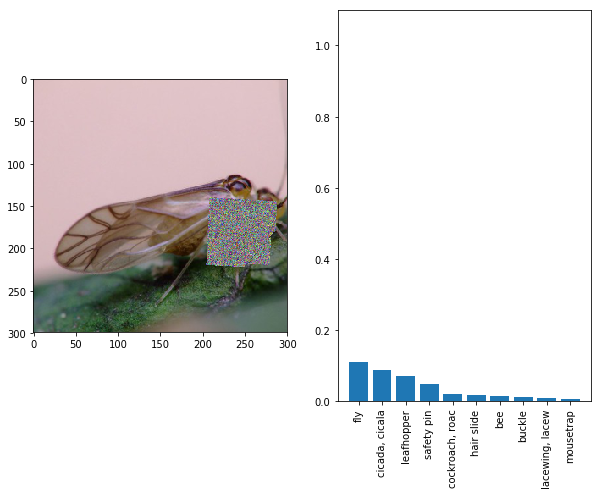

In [16]:
# post_proc_adv_patch = image_utils.postprocessing(ex_naive_patch)
# image_utils.show_probs(post_proc_adv_patch, ex_adv_probs[image_num], 
#                        imagenet_labels, target_class=200)

# image_utils.plot_adversarial_image(ex_adv_image.reshape(300, 300, 3))

# print(ex_adv_images[3][50])

image_num = 1
print(imagenet_labels[200])
post_proc_adv_images = image_utils.postprocessing(ex_adv_images)
image_utils.show_probs(post_proc_adv_images[image_num], ex_adv_probs[image_num], 
                       imagenet_labels, target_class=200)

# Run validation

### Init accuracies

In [77]:
# init metrics
lowest_prob_valid = 1.0
average_prob_valid = 0
top_5_probs_valid = 0

# init helper values to calculate metrics
sum_prob_valid = 0
top_5_counter_valid = 0
current_steps_valid = 0

### Run validation

In [78]:
num_steps = 100

folder_with_validation = "ImageNet/validation_set"

my_feed_dict = {
    x_shifts: 0,
    y_shifts: 0,
    start_x: 10,
    start_y: size,
    end_x: size,
    end_y: 20,
    thickness: 10,
    learning_rate: 1,
    target_class: 200,
    train_images: train_set,
    degrees: 0
}

with tf.Session() as sess:
    # load weights of the model
    inception_saver.restore(sess, './inception_v3_2016_08_28/inception_v3.ckpt')
    
    patch_saver.restore(sess, folder_for_patch_chkpt + str(size) + 'x' + str(size) + '/patch' + \
                           str(size) + 'x' + str(size))


    # make gradient updates
    for i in range(num_steps):
        # sample fold
        my_feed_dict[thickness] = np.random.randint(1, size // 10)
        my_feed_dict[start_x], my_feed_dict[start_y], my_feed_dict[end_x], my_feed_dict[end_y] = \
            image_utils.fold_sampler(size, my_feed_dict[thickness])
        
        # sample location
        my_feed_dict[x_shifts] = np.random.randint(0, 300 - size - size // 10 - 1)
        my_feed_dict[y_shifts] = np.random.randint(0, 300 - size - size // 10 - 1)
        
        # sample rotation
        my_feed_dict[degrees] = np.random.randint(-15, 15)
        
        # sample images:
        validation_set = image_utils.sample_image_wrapper(number_of_images, folder_with_validation)
        
        # check probabilities
        ex_adv_probs = sess.run(probs, feed_dict=my_feed_dict)
        
        if (i+1)%5 == 0: print("Running step", i+1)
        
        # infer information from received probabilities
        for j in range(number_of_images):
            # get the sum of probailities to calculate average probability
            sum_prob_valid += ex_adv_probs[j][my_feed_dict[target_class]]
            
            # get the number of cases where target class is presented in top-5 probabilities
            if my_feed_dict[target_class] in ex_adv_probs[j].argsort()[-5:]:
                top_5_counter_valid += 1
                
            
            # update the lowest probability
            if ex_adv_probs[j][my_feed_dict[target_class]] < lowest_prob_valid: 
                lowest_prob_valid = ex_adv_probs[j][my_feed_dict[target_class]]
            
            


current_steps_valid += num_steps
top_5_probs_valid = top_5_counter_valid/(current_steps_valid * number_of_images)
average_prob_valid  = sum_prob_valid/(current_steps_valid * number_of_images)

INFO:tensorflow:Restoring parameters from ./inception_v3_2016_08_28/inception_v3.ckpt
INFO:tensorflow:Restoring parameters from ./patch_weights/shift_rotate/100x100/patch100x100
Running step 5
Running step 10
Running step 15
Running step 20
Running step 25
Running step 30
Running step 35
Running step 40
Running step 45
Running step 50
Running step 55
Running step 60
Running step 65
Running step 70
Running step 75
Running step 80
Running step 85
Running step 90
Running step 95
Running step 100


In [79]:
print("Average accuracy: ", average_prob_valid)
print("Lowest accuracy: ", lowest_prob_valid)
print("Top-5 accuracy: ", top_5_probs_valid)

Average accuracy:  0.9821708011627197
Lowest accuracy:  0.53795016
Top-5 accuracy:  1.0


# Run test 

In [81]:
# init metrics
lowest_prob_test = 1.0
average_prob_test = 0
top_5_probs_test = 0

# init helper values to calculate metrics
sum_prob_test = 0
top_5_counter_test = 0
current_steps_test = 0

In [83]:
num_steps = 100

folder_with_validation = "ImageNet/test_set"

my_feed_dict = {
    x_shifts: 0,
    y_shifts: 0,
    start_x: 10,
    start_y: size,
    end_x: size,
    end_y: 20,
    thickness: 10,
    learning_rate: 1,
    target_class: 200,
    train_images: train_set,
    degrees: 0
}

with tf.Session() as sess:
    # load weights of the model
    inception_saver.restore(sess, './inception_v3_2016_08_28/inception_v3.ckpt')
    
    patch_saver.restore(sess, folder_for_patch_chkpt + str(size) + 'x' + str(size) + '/patch' + \
                           str(size) + 'x' + str(size))


    # make gradient updates
    for i in range(num_steps):
        # sample fold
        my_feed_dict[thickness] = np.random.randint(1, size // 10)
        my_feed_dict[start_x], my_feed_dict[start_y], my_feed_dict[end_x], my_feed_dict[end_y] = \
            image_utils.fold_sampler(size, my_feed_dict[thickness])

        
        # sample location
        my_feed_dict[x_shifts] = np.random.randint(0, 300 - size - size // 10 - 1)
        my_feed_dict[y_shifts] = np.random.randint(0, 300 - size - size // 10 - 1)
        
        # sample rotation
        my_feed_dict[degrees] = np.random.randint(-15, 15)
        
        # sample images:
        validation_set = image_utils.sample_image_wrapper(number_of_images, folder_with_validation)
        
        # check probabilities
        ex_adv_probs = sess.run(probs, feed_dict=my_feed_dict)
        
        if (i+1)%5 == 0: print("Running step", i+1)
        
        # infer information from received probabilities
        for j in range(number_of_images):
            # get the sum of probailities to calculate average probability
            sum_prob_test += ex_adv_probs[j][my_feed_dict[target_class]]
            
            # get the number of cases where target class is presented in top-5 probabilities
            if my_feed_dict[target_class] in ex_adv_probs[j].argsort()[-5:]:
                top_5_counter_test += 1
                
            
            # update the lowest probability
            if ex_adv_probs[j][my_feed_dict[target_class]] < lowest_prob_test: 
                lowest_prob_test = ex_adv_probs[j][my_feed_dict[target_class]]
            
            


current_steps_test += num_steps
top_5_probs_test = top_5_counter_test/(current_steps_test * number_of_images)
average_prob_test  = sum_prob_test/(current_steps_test * number_of_images)

INFO:tensorflow:Restoring parameters from ./inception_v3_2016_08_28/inception_v3.ckpt
INFO:tensorflow:Restoring parameters from ./patch_weights/shift_rotate/100x100/patch100x100
Running step 5
Running step 10
Running step 15
Running step 20
Running step 25
Running step 30
Running step 35
Running step 40
Running step 45
Running step 50
Running step 55
Running step 60
Running step 65
Running step 70
Running step 75
Running step 80
Running step 85
Running step 90
Running step 95
Running step 100


In [84]:
print("Average accuracy: ", average_prob_test)
print("Lowest accuracy: ", lowest_prob_test)
print("Top-5 accuracy: ", top_5_probs_test)

Average accuracy:  0.9845796162883441
Lowest accuracy:  0.4337065
Top-5 accuracy:  1.0


In [85]:
print(image_utils.fold_sampler(100, 10))


(46, 100, 100, 62)
